# Saving and loading

We often want to save the parameters of a trained model, so that we can use it again later without needing to re-train. 

All Feedbax components—including, automatically and for free, any that you might write—are [PyTrees](/feedbax/examples/pytrees): they are represented as tree-structured data. Equinox is able to [save](https://docs.kidger.site/equinox/examples/serialisation/) this data to a file. 

Feedbax provides some functions to make this slightly easier. However, you can also [learn](https://docs.kidger.site/equinox/api/serialisation/) to use the Equinox functions `tree_serialise_leaves` and `tree_deserialize_leaves`, if you prefer a different scheme for saving and loading.

Here's an example of how to use the functions provided by Feedbax. 

We'll start by writing a function that sets up the components we're going to want to save.

In [1]:
import jax

from feedbax.task import SimpleReaches

from feedbax.xabdeef.losses import simple_reach_loss
from feedbax.xabdeef.models import point_mass_nn


# The leading asterisk forces all the arguments to be passed as keyword arguments
def setup(*, workspace, n_steps, dt, hidden_size, key):

    task = SimpleReaches(
        loss_func=simple_reach_loss(),
        workspace=workspace,
        n_steps=n_steps
    )

    model = point_mass_nn(task, dt=dt, hidden_size=hidden_size, key=key)

    return task, model

Use this function to construct task and model objects. 

Let's keep all the arguments we pass to `setup` together in a dictionary called `hyperparameters`, since we'll want to save them along with the model.

In [2]:
hyperparameters = dict(
    workspace=((-1., -1.),  # Workspace bounds ((x_min, y_min), (x_max, y_max)
               (1., 1.)),
    n_steps=100,  # Number of time steps per trial
    dt=0.05,  # Duration of a time step
    hidden_size=50,  # Number of units in the hidden layer of the controller
)

key_init, key_train, key_eval = jax.random.split(jax.random.PRNGKey(0), 3)

task, model = setup(**hyperparameters, key=key_init)

Now train the model to perform the task. We'll just do a short run of 500 batches, since in this case we're interested in whether a model can be successfully saved and reloaded, not whether it's fully converged on a solution.

In [3]:
import optax

from feedbax.train import TaskTrainer


trainer = TaskTrainer(
    optimizer=optax.adam(learning_rate=1e-2)
)

model_trained, _ = trainer(
    task=task,
    model=model,
    n_batches=500,
    batch_size=250,
    where_train=lambda model: model.step.net,
    key=key_train,
)

Training step compiled in 2.66 seconds.
Validation step compiled in 2.12 seconds.


train batch:   0%|          | 0/500 [00:00<?, ?it/s]


Training iteration: 0
	training loss: 2.69e+01
	validation loss: 6.50e+00

Training iteration: 100
	training loss: 7.41e-02
	validation loss: 1.28e-02

Training iteration: 200
	training loss: 7.83e-03
	validation loss: 1.41e-03

Training iteration: 300
	training loss: 6.45e-03
	validation loss: 1.12e-03

Training iteration: 400
	training loss: 5.12e-03
	validation loss: 9.90e-04

Training iteration: 499
	training loss: 4.58e-03
	validation loss: 8.76e-04

Completed training run on a total of 125,000 trials.


Here's how we can save both the task and the trained model to a file.

In [4]:
from feedbax import save, load

save_path = "example_save.eqx"

save(
    save_path,
    (task, model_trained),
    hyperparameters=hyperparameters,
)

Now, immediately load it again.

In [5]:
task_loaded, model_loaded = load(save_path, setup)

How does this work? 

The short version is that `setup` is a reproducible way to construct our model and our task, which is reused by [`load`][feedbax.load] to reconstruct them in exactly the same way, before replacing their parameters with the saved (trained) ones from the file created by [`save`][feedbax.save].

The slightly longer version: the shape of the data we pass to `save` has to match what's constructed by the `setup` function. In this case, that's a tuple `task, model`. Between save time and load time, of course we need to store the file that was created by `save`. *But we also store the source code for `setup`*. At load time, we pass `setup` to `load`, along with the location of the saved file. First, `load` uses the `hyperparameters` stored in the file to call `setup` the same way we originally did, producing a skeleton `task, model`, which is then filled with the parameters from the `task, model` that had been passed to `save`.

??? Warning "Don't use pickle"      
    Python includes the module [`pickle`](https://docs.python.org/3/library/pickle.html), which can save and load entire Python objects without needing to specify, at the time of loading, how those objects were created—that is, it doesn't require us to hold on to a function like `setup` between save time and load time. This seems convenient, but it is not good practice in general:

    - Upon loading, Python will automatically execute code found in a pickle file, in order to reconstruct the pickled objects. This is a security issue. If someone shares a pickled model with you, they (or an interloper) could insert harmful code into the pickle file, and you may not know it's there until you run it.
    - Some of the components we use, such as `lambda` expressions, are not compatible with `pickle`.
    - You probably still have to keep track of how the objects in the pickle were created, for your research to be reproducible in detail. You could pickle `setup` as well—you could try to pickle *all* of your code, even—except you'd still run into the preceding issues. In the long run, the more explicit and organized solution is preferable, though it takes a little more work to start.
    
    See the Equinox [documentation](https://docs.kidger.site/equinox/examples/serialisation/) for a similar discussion of these limitations.

In general, `save` and `load` can be used to save the contents of *any* PyTree, so long as it's the same kind of PyTree returned by the setup function. That doesn't have to be `(task, model)`. Sometimes we might just care about storing the model, and not the task.

```python
def setup(*, .., key):
    model = ..
    return model

model = setup(**hyperparameters, key=key_init)
    
# Train the model (omitted).
# ...

save(
    save_path, 
    model,
    hyperparameters=hyperparameters,
)
    
model = load(save_path, setup)
```

Or, we could achieve the same thing by wrapping an existing setup function to make sure its return value matches what we pass to `save`.

In [6]:
save_path_model_only = "example_save_model_only.eqx"

save(
    save_path_model_only,
    model_trained,
    hyperparameters=hyperparameters,
)

# Wrapper that turns a function that returns `task, model`
# into a function that returns `model`
def setup_model_only(**kwargs):
    _, model = setup(**kwargs)
    return model

model_loaded = load(
    save_path_model_only,
    setup_model_only,
)

Finally, we can compare the trained model before and after reloading, to show that the process of saving to a file preserves the model.

First, the original:

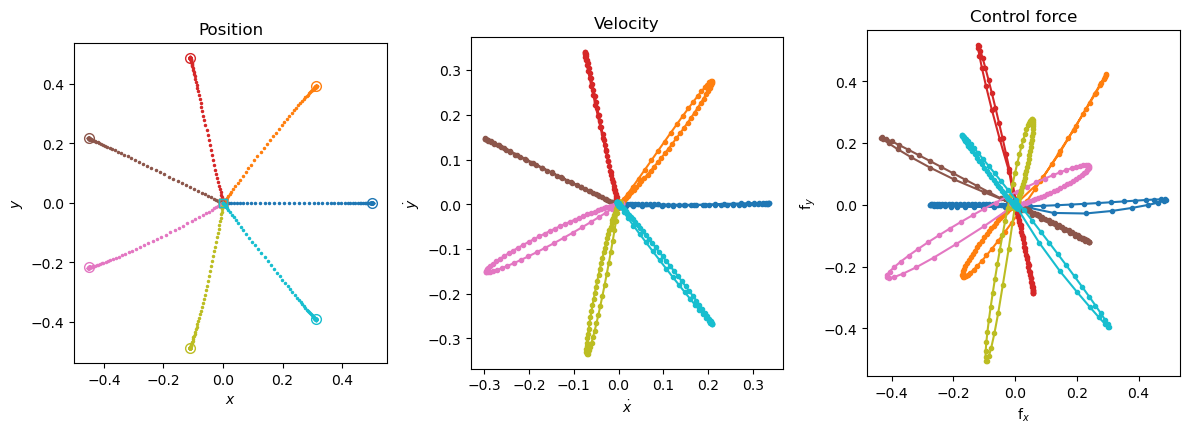

In [7]:
from feedbax.plot import plot_reach_trajectories

states = task.eval(model_trained, key=key_eval)

_ = plot_reach_trajectories(
    states,
    trial_specs = task.validation_trials,
)

And the reloaded copy:

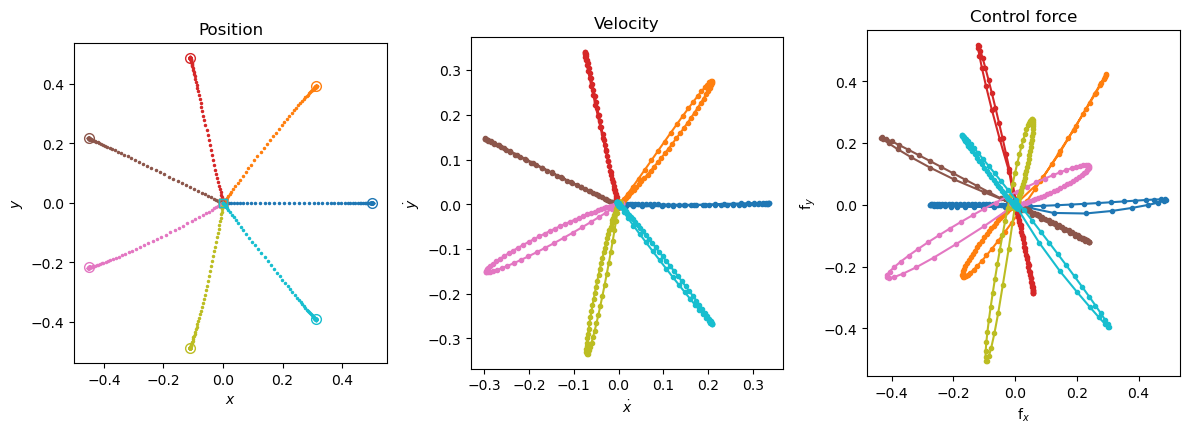

In [8]:
states = task_loaded.eval(model_loaded, key=key_eval)

_ = plot_reach_trajectories(
    states,
    trial_specs = task.validation_trials,
)